In [1]:
from google.colab             import drive
drive.mount ('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




PART 1 Start: Bigger classes classification
	> Reading data file...
	> Extracting smaller categories...
	> Synthetically generating new smaller categories...
	> Synthetically generating new minimal categories...
	> Oversampling smaller categories...
	> Down Sampling larger classes...
	> Combining preprocessed data...
	> Extracting training data...
	> Encoding Target...
	> Encoding Input...
	> Splitting into Train and Test Data...
	> Scaling Input...
	> PCA: Reducing dimensions...
	> Random Forest: Training model...
	> Inverse Target Encoding...

---------------- Classification report for PART 1 (Random Forest) ---------------------

              precision    recall  f1-score   support

       back.      1.000     0.998     0.999       464
    ipsweep.      0.995     0.996     0.995      2514
    neptune.      1.000     1.000     1.000     39698
       nmap.      0.986     0.977     0.982       440
     normal.      0.999     1.000     1.000     40418
      other.      0.999     1.00

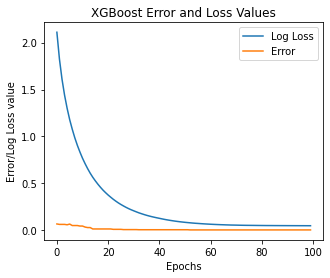

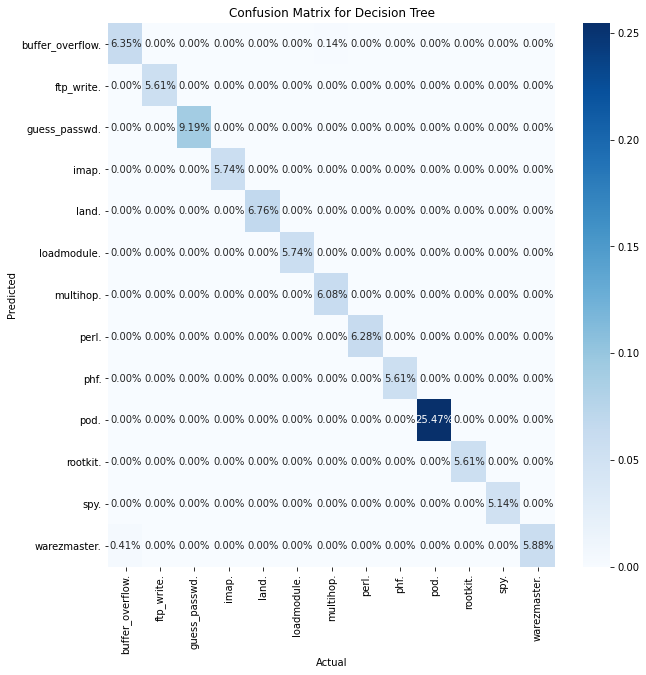

In [2]:
#@title
#!pip install imbalanced-learn     #Uncomment this line if imbalanced-learn is not installed

import shelve;
import warnings;
import time;
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches
import pandas             as pd;
import numpy              as np;
import seaborn            as sns;
import matplotlib.pyplot  as plt;
from xgboost                  import plot_tree
from sklearn.compose          import make_column_transformer
from sklearn.preprocessing    import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import confusion_matrix, accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics          import balanced_accuracy_score, precision_score, recall_score
from sklearn.decomposition    import PCA
from sklearn.utils            import resample
from imblearn.over_sampling   import RandomOverSampler
from xgboost                  import XGBClassifier
from sklearn.ensemble         import RandomForestClassifier
from imblearn.over_sampling   import SMOTENC

########################## Part 1 Bigger Classes classification ##########################
print("\n\nPART 1 Start: Bigger classes classification")

############# Prediction pipeline function #############
print("\t> Reading data file...")

sh_file   = '/content/drive/MyDrive/Data/shelf_central'
data_path = '/content/drive/MyDrive/Data/kddcup.data.corrected'

df        = pd.read_csv(data_path, header=None);


for i in range(42):                                       # Rename columns
  df.rename(columns = {i: str(i)}, inplace = True) 

plt1a = df['41'].value_counts()


############ Combining smaller categories ############
print("\t> Extracting smaller categories...")

tmp = pd.DataFrame();
df2 = pd.DataFrame();

few = ['spy.','perl.','phf.','multihop.','ftp_write.','loadmodule.','rootkit.','imap.','warezmaster.','land.','buffer_overflow.','guess_passwd.','pod.']
for fff in few:
  tmp = df.loc[df['41'] == fff];
  df2 = pd.concat([df2,tmp]);
  df.drop(df[df['41'] == fff].index ,inplace=True);    


########### SMOTE Smaller categories ###############
print("\t> Synthetically generating new smaller categories...")


td = df.loc[df['41'] == 'normal.'];
td = resample(td, replace=False, n_samples=50, random_state=1);   ##### C point - size of smaller sample smotes

for i in range(42):                                      
  df2.rename(columns = {i: str(i)}, inplace = True);

few = ['multihop.','ftp_write.','loadmodule.','rootkit.','imap.','warezmaster.','land.','buffer_overflow.','guess_passwd.','pod.'];
smotenc = SMOTENC([1,2,3,6,11,20,21], random_state=1);

for smaller in few:
  tt = df2.loc[df2['41'] == smaller];
  df_tmp = pd.concat([tt,td]);

  X_tmp  = df_tmp.iloc[:,:-1];
  Y_tmp  = np.array(df_tmp.iloc[:,-1]);
  Y_tmp  = Y_tmp.reshape(len(Y_tmp),1);

  X_tmpo ,Y_tmpo = smotenc.fit_resample(X_tmp,Y_tmp);

  X_tmpo = pd.DataFrame(X_tmpo);
  Y_tmpo = pd.DataFrame(Y_tmpo);
  X_tmpo.rename(columns={'0':'123'});

  if smaller == few[0]:
    X_tmt = X_tmpo;
    Y_tmt = Y_tmpo;
  else:
    X_tmt = pd.concat([X_tmt,X_tmpo]); 
    Y_tmt = pd.concat([Y_tmt,Y_tmpo]); 


df_synthesised = pd.DataFrame(np.concatenate((X_tmt,Y_tmt), axis=1));
df_synthesised.drop(df_synthesised[df_synthesised[41] == 'normal.'].index ,inplace=True);

for i in range(42):                                    
  df_synthesised.rename(columns = {i: str(i)}, inplace = True);



########### SMOTE Minimal categories ###############
print("\t> Synthetically generating new minimal categories...")


td = df.loc[df['41'] == 'normal.'];
td = resample(td, replace=False, n_samples=200, random_state=1);              ##### C point - size of really small smotes

few = ['spy.','perl.','phf.'];
smotenc = SMOTENC([1,2,3], random_state=1);


for smaller in few:
  tt     = df2.loc[df2['41'] == smaller];
  tt     = resample(tt, replace=True, n_samples=10, random_state=1);
  df_tmp = pd.concat([tt,td]);

  X_tmp  = df_tmp.iloc[:,:-1];
  Y_tmp  = np.array(df_tmp.iloc[:,-1]);
  Y_tmp  = Y_tmp.reshape(len(Y_tmp),1);

  X_tmpo ,Y_tmpo = smotenc.fit_resample(X_tmp,Y_tmp);

  X_tmpo = pd.DataFrame(X_tmpo);
  Y_tmpo = pd.DataFrame(Y_tmpo);
  X_tmpo.rename(columns={'0':'123'});

  if smaller == few[0]:
    X_tmt = X_tmpo;
    Y_tmt = Y_tmpo;
  else:
    X_tmt = pd.concat([X_tmt,X_tmpo]); 
    Y_tmt = pd.concat([Y_tmt,Y_tmpo]); 


dft = pd.DataFrame(np.concatenate((X_tmt,Y_tmt), axis=1));
dft.drop(dft[dft[41] == 'normal.'].index ,inplace=True);

for i in range(42):                                     
  dft.rename(columns = {i: str(i)}, inplace = True);

df_synthesised = pd.concat([df_synthesised, dft]);


########### Oversampling ###########
print("\t> Oversampling smaller categories...")

df_oversampled = resample(df_synthesised, replace=True, n_samples=30000, random_state=1);  ###### C Point - Oversampling weight
df_synthesised = pd.concat([df_synthesised,df_oversampled]);

df_synthesised['41'] = 'other.'


########### Down Sampling ###########
print("\t> Down Sampling larger classes...")

df_down = df;

for str1 in ['normal.','smurf.', 'neptune.']:
  new = df_down.loc[df_down['41']==str1]
  if str1 == 'normal.':
    new = new.sample(n=200000, replace=False, random_state=1 );
  else:
    new = new.sample(n=200000, replace=False, random_state=1 );
  df_down.drop(df_down[df_down['41']==str1].index ,inplace=True)
  df_down = pd.concat([new, df_down]);

########### Combining all data ###########
print("\t> Combining preprocessed data...")

df = pd.concat([df_down,df_synthesised]);
plt1b = df['41'].value_counts();


############ Getting Training data ############
print("\t> Extracting training data...")
X  = df.iloc[:,:-1];
Y  = np.array(df.iloc[:,-1]);
Y  = Y.reshape(len(Y),1)


############ Target Encoding ############
print("\t> Encoding Target...")
TE = LabelEncoder();
TE.fit(Y);
Y  = TE.transform(Y);
Y  = Y.astype(float)



############ Input Encoding for columns 1,2,3 ############
print("\t> Encoding Input...")
IE = make_column_transformer((OneHotEncoder(),['1','2','3']),remainder = 'passthrough');
IE.fit(X);
X = pd.DataFrame(IE.transform(X));




############ Train test split (80%, 20% ratio) ############
print("\t> Splitting into Train and Test Data...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1);
Y_train = Y_train.reshape(len(Y_train),1)
Y_test  = Y_test.reshape(len(Y_test),1)



############# Scaling Input #############
print("\t> Scaling Input...")
SCALE_IN  = StandardScaler();
SCALE_IN.fit(X_train);
X_train = SCALE_IN.transform(X_train);


X_test  = SCALE_IN.transform(X_test);




############# Dimensinality reduction with PCA ############
print("\t> PCA: Reducing dimensions...")
DR = PCA(n_components=90)
DR.fit(X_train)
X_train = DR.transform(X_train)

X_test  = DR.transform(X_test)


############# Random Forest Model #############
print("\t> Random Forest: Training model...")
Y_train = Y_train.flatten();
Y_test  = Y_test.flatten();

MODEL = RandomForestClassifier(n_estimators=50 ,random_state=1)
MODEL.fit(X_train, Y_train)
Y_pred = MODEL.predict(X_test)

Y_pred_prob = MODEL.predict_proba(X_test)


############# Inverse Label Encoding and Results #############
print("\t> Inverse Target Encoding...")
Y_pred = pd.DataFrame(TE.inverse_transform(Y_pred.astype(int)))
Y_test = pd.DataFrame(TE.inverse_transform(Y_test.astype(int)))

print("\n---------------- Classification report for PART 1 (Random Forest) ---------------------\n")
print(classification_report(Y_test,Y_pred,digits=3))
print("\n---------------------------------------------------------------------------------------\n")



########################## Part 2 Smaller classes ##########################
print("\n\nPART 2 Start: Smaller 'other.' category sub-classification...")

############# Getting Data #############
print("\t> Getting training data...")
df3 = df2.iloc[:,:]

plt2a = df3['41'].value_counts();

df3 = resample(df2, replace=True, n_samples=1500, random_state=1)
X3 = df3.iloc[:,:-1];
Y3 = df3.iloc[:,-1];

for i in range(41):                                       
  X3.rename(columns = {i: str(i)}, inplace = True) 


############# Encode #############
print("\t> Encoding Input...")
X3 = pd.DataFrame(IE.transform(X3));


############# Oversampling #############
print("\t> Oversampling...")
SC2 = RandomOverSampler()
x22 = df2.iloc[:,:-1];
x22 = IE.transform(x22);

y22 = df2.iloc[:,-1];
x22,y22 = SC2.fit_resample(x22,y22)

x22 = pd.DataFrame(x22)
y22 = pd.DataFrame(y22)

X2 = pd.concat([X3,x22]);
Y2 = pd.concat([Y3,y22]);

plt2b= Y2.value_counts();


############# Target encode #############
print("\t> Encoding Target...")
T2 = LabelEncoder();
T2.fit(Y2);
Y2 =pd.DataFrame(T2.transform(Y2));


############# Train Test Data Split  #############
print("\t> Splitting into Train and Test Data...")
X2,X_tt,Y2,Y_tt =  train_test_split(X2, Y2, test_size=0.3, random_state=1);
D_tmp = pd.DataFrame(np.hstack((X2, Y2)))
D_tmp = resample(D_tmp, replace=False, n_samples=500, random_state=1);
X2 = D_tmp.iloc[:,:-1];
Y2 = D_tmp.iloc[:,-1];

ESET = [(X_tt,Y_tt)] 


############# XGB #############
print("\t> XGB: Training model...")
MODEL2 = XGBClassifier()
MODEL2.fit(X2,Y2, eval_metric=["merror", "mlogloss"], eval_set=ESET, verbose=False);
Y_tp = MODEL2.predict(X_tt)

Y_tt = Y_tt.astype(int)
Y_tp = Y_tp.astype(int)
Y_tt    = T2.inverse_transform(Y_tt);
Y_tp    = T2.inverse_transform(Y_tp);



print("\n-------------------- Classification report for PART 2 (XGBoost) -----------------------\n")
print(classification_report(Y_tt,Y_tp,digits=3)[0:57])
print(classification_report(Y_tt,Y_tp,digits=3)[-175:])
print("\n---------------------------------------------------------------------------------------\n")



plt.rcParams["figure.figsize"] = (5,4);
RES = MODEL2.evals_result();
NUM = len(RES['validation_0']['merror']);
G1  = range(0, NUM);
GRAPH, G2 = plt.subplots();
G2.plot(G1, RES['validation_0']['mlogloss'], label='Log Loss');
G2.plot(G1, RES['validation_0']['merror']  , label='Error');
G2.legend();
plt.ylabel('Error/Log Loss value');
plt.xlabel('Epochs')
plt.title('XGBoost Error and Loss Values');
plt.show();


plt.rcParams["figure.figsize"] = (10,10);
cm1 = confusion_matrix(Y_tt,Y_tp);
labelsi = np.unique(Y_tt)
labelsc = np.unique(Y_tp)
if len(labelsi) > len(labelsc):
  labelled = labelsi
else:
  labelled = labelsc
sns.heatmap(cm1/np.sum(cm1), annot=True, fmt='.2%', cmap='Blues', xticklabels=labelled, yticklabels=labelled);
plt.title('Confusion Matrix for Decision Tree');
plt.ylabel('Predicted');
plt.xlabel('Actual');
plt.show();



PART 3: Testing overall trained model
	> Creating prediction pipeline function...
	> Reading file...
	> Sampling random test data...

	PREDICTOR() called: 40000 Columns to predict!
	• Diving columns..
	• Encoding..
	• Scaling..
	• Reducing dimensions...
	• Random Forest Prediction...
	• Decoding...
	• Finding indexes 'other.' indexes...
	• XGB Prediction...
	• PREDICTOR: Complete


--------- Classification report for Overall performance (R. Forest + XGBoost) ---------

                  precision    recall  f1-score   support

        accuracy                          1.000     40000
       macro avg      0.923     0.922     0.923     40000
    weighted avg      1.000     1.000     1.000     40000


---------------------------------------------------------------------------------------

	> Generating performance metrics for 25 random samples...
Metrics averaged over 25 samples:
	Average F1 Score - 0.942720616644904
	Average Accuracy - 0.999918


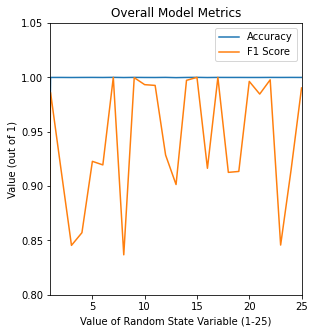

	> Generating speed charachteristics for 25 random samples...


Average Speed of prediction for 25 samples - 54446.03311919498 packets/sec


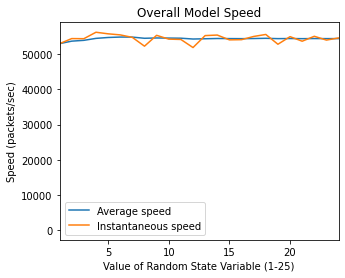

	> Finding protocol based accuracies...


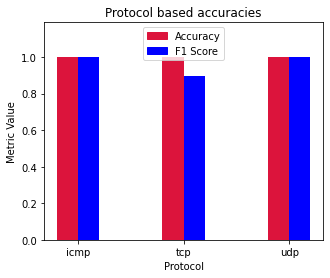



PART 4 Start: Shelving models, encoders etc...


				 THANK YOU


In [5]:
########################## Part 3 Prediction pipleine and testing ##########################
print("\n\nPART 3: Testing overall trained model")

############# Prediction pipeline function #############
print("\t> Creating prediction pipeline function...")

def PREDICTOR(data, verbose=1):
  d = pd.DataFrame(data);
  sh = d.shape;
  if verbose==1:
    print("\n\tPREDICTOR() called: {} Columns to predict!".format(sh[0]));
  if sh[1]==41:

    # Column naming
    for i in range(41):
      d.rename(columns = {i: str(i)}, inplace = True) 
      
    # Column division
    if verbose==1:
      print("\t\u2022 Diving columns..")
    X_pred = d.iloc[:,:];

    # Encoding categorical variables
    if verbose==1:
      print("\t\u2022 Encoding..")
    X_pred = pd.DataFrame(IE.transform(X_pred));

    # Scaling
    if verbose==1:
      print("\t\u2022 Scaling..")
    X_pred = SCALE_IN.transform(X_pred);

    # Dimensionality reduction with PCA
    if verbose==1:
      print("\t\u2022 Reducing dimensions...")
    X_pred = DR.transform(X_pred);
  
    # Prediction
    if verbose==1:  
      print("\t\u2022 Random Forest Prediction...")
    Y_pred = MODEL.predict(X_pred);
    
    # Decoding
    if verbose==1:
      print("\t\u2022 Decoding...")
    Y_ret = pd.DataFrame(TE.inverse_transform(Y_pred.astype(int)));

    # Finding indexes of the 'object.' predictions
    if verbose==1:
      print("\t\u2022 Finding indexes 'other.' indexes...");
    index = Y_ret.index;
    condition = Y_ret[0] == 'other.'
    idx_all = index[condition];

    # Classifying 'object.' further
    if verbose==1:
      print("\t\u2022 XGB Prediction...")
    for ind in idx_all:
      X_ret = pd.DataFrame(d.iloc[[ind,0],:]);
      X_ret = pd.DataFrame(IE.transform(X_ret));
      Y_re  = MODEL2.predict(X_ret);
      Y_re  = Y_re.astype(int)
      Y_re  = pd.DataFrame(T2.inverse_transform(Y_re));
      Y_ret[0][ind]=Y_re[0][0];

    if verbose==1:
      print("\t\u2022 PREDICTOR: Complete\n");
    return pd.DataFrame(Y_ret);

  else:
    if verbose==1:
      print("Error! Wrong format of input!");
    return 0;


############# Overall training test #############
print("\t> Reading file...")
#Note: Use the dataframe df_backup to assign test bench data, not df.
df_backup        = pd.read_csv(data_path, header=None);

print("\t> Sampling random test data...")
finalT = pd.DataFrame(df_backup .sample(n=40000, replace=False, random_state=18 ))


X_finalT = pd.DataFrame(finalT.iloc[:,:-1]);
Y_finalT = pd.DataFrame(finalT.iloc[:,-1]);
Y_finalP = PREDICTOR(X_finalT)

Y_t3 = Y_finalT;
Y_p3 = Y_finalP;

acc = accuracy_score(Y_finalT,Y_finalP)
f1c = f1_score(Y_finalT,Y_finalP, average='macro')

print("\n--------- Classification report for Overall performance (R. Forest + XGBoost) ---------\n")
print(classification_report(Y_t3,Y_p3,digits=3)[0:57]);
print(classification_report(Y_t3,Y_p3,digits=3)[-175:]);
print("\n---------------------------------------------------------------------------------------\n")



############# Performance Metrics #############
print("\t> Generating performance metrics for 25 random samples...")

f1c = 0;
acc = 0;
ac_values = np.array([0]);
f1_values = np.array([0]);

for rx in range(25):
  finalT = pd.DataFrame(df_backup .sample(n=40000, replace=False, random_state=rx+14 ))

  X_finalT = pd.DataFrame(finalT.iloc[:,:-1]);
  Y_finalT = pd.DataFrame(finalT.iloc[:,-1]);

  Y_finalP = PREDICTOR(X_finalT,0);                       # Non verbose silent run

  a1 = accuracy_score(Y_finalT,Y_finalP)
  f1 = f1_score(Y_finalT,Y_finalP, average='macro')
  acc = acc + a1;
  f1c = f1c + f1;

  #print("ACC - "+str(a1)+"\nF1  - "+str(f1));
  ac_values =np.append(ac_values,a1);
  f1_values =np.append(f1_values,f1);

f1c = f1c/25;
acc = acc/25;

print("Metrics averaged over 25 samples:")
print("\tAverage F1 Score - "+str(f1c));
print("\tAverage Accuracy - "+str(acc));


plt.plot(ac_values,label = 'Accuracy');
plt.plot(f1_values,label = 'F1 Score' );
plt.legend();
plt.xlabel("Value of Random State Variable (1-25)");
plt.ylabel("Value (out of 1)")
plt.ylim(0.8,1.05);
plt.xlim(0.99,25);
plt.rcParams["figure.figsize"] = (5,4);
plt.title('Overall Model Metrics')
plt.show();

############# Prediction speed #############
print("\t> Generating speed charachteristics for 25 random samples...")

time_total    = 0;
sample_total  = 0;
time_values   = np.array([0]);
sample_values = np.array([0]);
avg_speed     = np.array([0]);
inst_speed    = np.array([0]);

for rx in range(26):
  finalT = pd.DataFrame(df_backup .sample(n=40000, replace=False, random_state=rx+1 ))

  X_finalT = pd.DataFrame(finalT.iloc[:,:-1]);
  t_init = time.clock();
  Y_finalP = PREDICTOR(X_finalT,0);                       # Non verbose silent run
  t1 = time.clock() - t_init;
  s1 = 40000
  time_total   = time_total   + t1;
  sample_total = sample_total + s1;

  if rx!=25:
    time_values   = np.append(time_values,t1);
    sample_values = np.append(sample_values,s1);
    avg_speed     = np.append(avg_speed,sample_total/time_total);
    inst_speed    = np.append(inst_speed,s1/t1);

print("\n\nAverage Speed of prediction for 25 samples - "+str(avg_speed[25])+" packets/sec");

plt.plot(avg_speed,label = 'Average speed');
plt.plot(inst_speed,label = 'Instantaneous speed' );
plt.legend();
plt.xlabel("Value of Random State Variable (1-25)");
plt.ylabel("Speed (packets/sec)")
plt.xlim(1,24);
plt.rcParams["figure.figsize"] = (5,4);
plt.title('Overall Model Speed')
plt.show();


############# UDP-TCP-ICMP accuracies #############
print("\t> Finding protocol based accuracies...")
finalT = pd.DataFrame(df_backup .sample(n=30000, replace=False, random_state=4))
acARRAY = np.array([0.0, 0.0, 0.0]);
f1ARRAY = np.array([0.0, 0.0, 0.0]);

i=0;
for str2 in ['icmp','tcp','udp']:
  PROTO  = finalT.loc[finalT[1]==str2]

  X_finalT = pd.DataFrame(PROTO.iloc[:,:-1]);
  Y_finalT = pd.DataFrame(PROTO.iloc[:,-1]);
  Y_finalP = PREDICTOR(X_finalT,0);                      
  acc = accuracy_score(Y_finalT,Y_finalP);
  f1c = f1_score(Y_finalT,Y_finalP,average='macro');
  acARRAY[i] = acc;
  f1ARRAY[i] = f1c;
  i+=1;

w=0.2;
plt.rcParams["figure.figsize"] = (5,4);
x = np.arange(len(acARRAY));
plt.bar(x, acARRAY,w, color='crimson',label='1')
plt.bar(x+w, f1ARRAY,w, color='blue',label='2')
plt.ylabel('Metric Value');
plt.ylim(0,1.19);
p1 = mpatches.Patch(color='crimson', label = 'Accuracy');
p2 = mpatches.Patch(color='blue'   , label = 'F1 Score');
plt.xlabel('Protocol');
plt.xticks(x+(w/2),['icmp','tcp','udp']);
plt.title('Protocol based accuracies');
plt.legend(handles=[p1,p2]);
plt.show();


finalT[21].value_counts()

########################## Part 4 Export Workspace ##########################
print("\n\nPART 4 Start: Shelving models, encoders etc...");

shelver = shelve.open(sh_file,'n') 

shelve_list = ['IE','SCALE_IN','DR','MODEL','TE','MODEL2','T2']

for k in shelve_list:
  try:
    shelver[k] = globals()[k]
  except TypeError:
    print('ERROR shelving: {}'.format(k))

shelver.close()
print("\n\n\t\t\t\t THANK YOU")


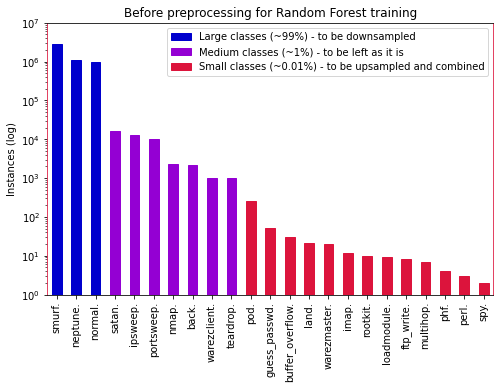

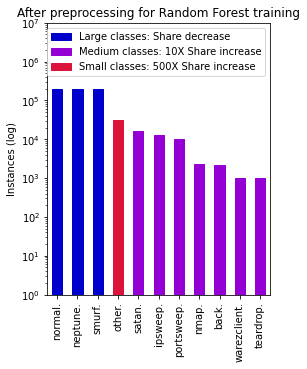

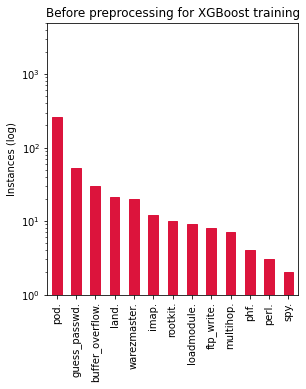

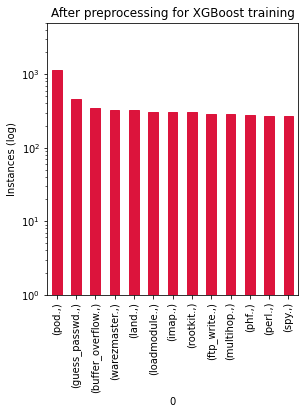

In [4]:
########################## Data Visualisation of Preprocessing stage ##########################

############# PLOT 1: Before preprocessing of Random Forest Training #############
col1 = 'mediumblue'
col2 = 'darkviolet'
col3 = 'crimson'


plt.rcParams["figure.figsize"] = (8,5);
FIG2  = plt.figure();
FIG2a = FIG2.add_subplot(111);
FIG2a = plt1a.plot(kind = 'bar');
for tt in range(25):
  if tt<3:
    FIG2a.get_children()[tt].set_color(col1);
  elif tt<10:
    FIG2a.get_children()[tt].set_color(col2);
  else:
    FIG2a.get_children()[tt].set_color(col3);


plt.yscale('log');
p1 = mpatches.Patch(color=col1, label = 'Large classes (~99%) - to be downsampled');
p2 = mpatches.Patch(color=col2, label = 'Medium classes (~1%) - to be left as it is');
p3 = mpatches.Patch(color=col3, label = 'Small classes (~0.01%) - to be upsampled and combined');


plt.ylim(1,10000000);
plt.title('Before preprocessing for Random Forest training');
plt.ylabel('Instances (log)');
plt.legend(handles=[p1,p2,p3]);
plt.show();
print('\n\n')


############# PLOT 2: After preprocessing of Random Forest Training #############

plt.rcParams["figure.figsize"] = (4,5);
FIG2  = plt.figure();
FIG2a = FIG2.add_subplot(111);
FIG2a = plt1b.plot(kind = 'bar');
for tt in range(25):
  if tt<3:
    FIG2a.get_children()[tt].set_color(col1);
  elif tt==3:
    FIG2a.get_children()[tt].set_color(col3);
  elif tt<11:
    FIG2a.get_children()[tt].set_color(col2);



plt.yscale('log');
p1 = mpatches.Patch(color=col1, label = 'Large classes: Share decrease');
p2 = mpatches.Patch(color=col2, label = 'Medium classes: 10X Share increase');
p3 = mpatches.Patch(color=col3, label = 'Small classes: 500X Share increase');

plt.ylim(1,10000000);
plt.title('After preprocessing for Random Forest training');
plt.ylabel('Instances (log)');
plt.legend(handles=[p1,p2,p3]);
plt.show();
print('\n\n')


############# PLOT 3: Before preprocessing of XGBoost Training #############

plt.rcParams["figure.figsize"] = (4.5,5);
FIG1  = plt.figure();
FIG1a = FIG1.add_subplot(111);
#plt.bar(width=[1,1]);
FIG1a = plt2a.plot(kind = 'bar');
for tt in range(13):
  FIG1a.get_children()[tt].set_color(col3);

plt.yscale('log');
plt.ylabel('Instances (log)');
plt.ylim(1,5000);
plt.title('Before preprocessing for XGBoost training');
plt.show();


############# PLOT 4: After preprocessing of XGBoost Training #############

plt.rcParams["figure.figsize"] = (4.5,5);
FIG1  = plt.figure();
FIG1a = FIG1.add_subplot(111);
#plt.bar(width=[1,1]);
FIG1a = plt2b.plot(kind = 'bar');
for tt in range(13):
  FIG1a.get_children()[tt].set_color(col3);

plt.yscale('log');
plt.ylabel('Instances (log)');
plt.ylim(1,5000);
plt.title('After preprocessing for XGBoost training');
plt.show();